# Gas station prediction

# Introduction/Business Problem

Gas stations are required throughout the city to supply fuel for transportation. They can often be found in dense retail sectors that have a variety of other venues present within a certain radius. Furthermore, you often see different companies opening gas stations in close approximation to each other.  

The problem is, how many gas stations are typically built to meet the needs of the community? This is a crucial problem for not only gas companies but also city planning. Allowing too many gas stations results in less area for local businesses to open their stores. The stations also have negative impacts on the environment as the sites they are built on cannot be used after the gas station is removed. Therefore, it would be beneficial to predict how many gas stations are typically built in any given area so that it can inform future design and build recommendations. (https://www.theglobeandmail.com/report-on-business/industry-news/property-report/life-after-corner-gas-the-challenges-of-developing-old-service-stations/article32219739/)  

Ottawa, ON Canada is going to be used as the test city as it has a variety of different retail spaces and city densities that can be a good representation of how gas stations are distributed.





# Data

The data that’s going to be used is primarily the Foursquare API data. First the location and label of the venues will be used to identify gas stations using the venues search endpoint and limiting the category. Secondly the other venues in the area will be identified grouped by their and counted.  Secondly, population data at an FSA (forward station area) level will be used. This data will be collected from Statistics Canada ( Example can be found here: https://www12.statcan.gc.ca/census-recensement/2016/dp-pd/hlt-fst/pd-pl/Table.cfm?Lang=Eng&T=1201&S=22&O=A). 

THe population is calculated by finding all of the FSAs within a 2Km radius and summing their populations. This was done using the website (https://www.freemaptools.com/find-canada-postcodes-inside-radius.htm). Requests were made to that website to obtain the FSAs and the Stats Canada data was used to group and sum the populations.

For each gas station in Ottawa, the number of gas stations located within a 2km radius will be identified and used as the dependent variable. The population of the gas station will be the total population of every FSA within a 2km radius. Similarly, only the other venues within a 2km radius will be used as predictors. The venues will be differentiated by category. Since there are many categories, the categories will be grouped by the highest level present in the FourSquare category hierarchy.

After the data is gathered and prepared a variety of regression based models will be used to predict the number of surrounding gas stations with the collected data. 


### Example of Foursquare API result.
#### Category data will be used in the analysis

## Data Collection Part 1: Inital Gas Station discovery

### Ottawa FSA
First, wikipedia was used as a source to get the FSAs present in Ottawa.

In [30]:
# Import required libraries
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
import time
import random

#Request html from wikipedia
result = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_K')
#Parse out each of the cells in the table containing the FSAs
bs = BeautifulSoup(result.content,"lxml")

#Iterate through the cells and pull out the FSA and City by parsing the <b> flag 
# This was done because only Ottawa was bolded along with its corresponding FSAs 

fsa_city = []
for i in bs.find_all("td"):
    try:
        fsa_city.append((i.find_all("b")[0].text.strip(),i.find_all("b")[1].text.strip()))
    except IndexError as e:
        continue
fsa_city = pd.DataFrame(fsa_city,columns=["FSA","City"]).iloc[1:,:]
fsa_city.head()

,FSA,City
1,K2A,Ottawa
2,K4A,Ottawa
3,K1B,Ottawa
4,K2B,Ottawa
5,K4B,Ottawa


### Initial Gas Station Parameters

Setting up variables for the first set of api calls to FourSquare. Im using the specific category ID for gas stations obtained from the foursquare website. Since the foursquare API search only returns the top 50 gas stations in a given area, i used google maps to choose overlapping points surrounding Ottawa. I then did an api call looking for the top 50 gas stations within a 25km radius. 

In [148]:

#Set request parameters
CLIENT_ID = 'RXXSQHKGPBE2ACCIEHZH1RQDSROXI4K4HWYGC0TIDSYYPCFF'
CLIENT_SECRET = '1PKOWDCF2MV2CSLDPPJB25FGBBU5AZHMTOAU0GM4P3SCRES4'
VERSION = '20200601'
gas_station_id = '4bf58dd8d48988d113951735'
city = 'Ottawa, ON'
limit = 50

# Points collected from Google maps to get a broad initial covereage
nw = (45.390671, -76.097741)
nn = (45.380876, -75.799434)
ne = (45.423567, -75.469810)
se = (45.218942, -75.550669)
ss = (45.111716, -75.838242)
grid_search = [nw,nn,ne,se,ss]


### Foursquare API Processing Functions

In [149]:
#Used as a check for getting the postal code and city (Some dont have these parameters filled)
def string_value_check(r,value):
    try:
        return r[value]
    except KeyError:
        return "None"
    
# Retrieves the venue info from a returned JSON result
def extract_venue_info(results):
    try:
        venue_raw = [

               (r['venue']['id'],
                r['venue']['name'],
                r['venue']['location']['lat'],
                r['venue']['location']['lng'],
                string_value_check(r["venue"]["location"],"postalCode"),
                string_value_check(r["venue"]["location"],"city"),
                r['venue']['categories'][0]['name']
                )
             for r in results['response']['groups'][0]['items']
                ]
    except KeyError as e:
        print(results)
        raise KeyError('Key Error Occured {}'.format(e))
    return pd.DataFrame(venue_raw,columns=result_columns)


### Initial Gas Station API Call
For each of the lat/lng pairs mentioned earlier, the API calls were made to discover the initial gas stations. 
Thorughout the data collection phase I am surrounding my intensive API calls with try/except blocks and saving the results as .csvs. This prevents me recalling the API if it is already saved as a file to reduce the number of calls needed

In [152]:
#First Resulting gas stations
result_columns = ["venue_id","venue_name","lat","lng","postal_code",'city',"category"]

#Initialize final dataframe
initial_gas_stations = pd.DataFrame(columns=result_columns)


try:
    initial_gas_stations = pd.read_csv("initial_gas_stations.csv")
except OSError:
    #Search for gas stations in a 25Km radius
    for lat, lng in grid_search:
        RADIUS = 25000
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&limit={}&radius={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                lat,
                lng,
                gas_station_id,
                limit,
                RADIUS
                )
        initial_gas_stations = initial_gas_stations.append(extract_venue_info(requests.get(url).json()))
    #Remove the inevitable duplicates from the overlapping areas
    initial_gas_stations = initial_gas_stations.drop_duplicates()
    initial_gas_stations.city.drop_duplicates()
    initial_gas_stations.to_csv("initial_gas_stations.csv",index=False)
    
#Limit the gas stations to only those that are found in postal codes that are considered to be in Ottawa
#If the postal code wasnt present but the city was, only include the gas station if the city = "Ottawa"
city_filter = (initial_gas_stations.postal_code.str[:3].isin(fsa_city.FSA))|(initial_gas_stations.city=="Ottawa")
initial_gas_stations = initial_gas_stations.loc[city_filter]
initial_gas_stations.head()

,venue_id,venue_name,lat,lng,postal_code,city,category
1,4b2b8249f964a520f8b624e3,Ralph & Son's,45.352134,-75.835712,None,Ottawa,Diner
2,4b26a38df964a520cd7e24e3,Shell,45.350954,-75.926538,K2K 2R9,Kanata,Gas Station
3,4b666374f964a520da1f2be3,Esso,45.342269,-75.917041,K2K 2M5,Ottawa,Gas Station
4,4c63230fde1b2d7f490be470,MacEWEN Gas,45.383418,-75.969626,K2K 1X7,Dunrobin,Gas Station
5,4c78288d81bca0930328f914,Petro-Canada,45.308107,-75.915422,K2T 1L2,Kanata,Gas Station


## Data collection Part II: Nearby Gas Station Discovery

This section has two main goals.
1. Get the number of gas stations within a 2Km radius of the ones found in the initial gas station query. 
2. Fill in the missing gaps due to the limit of 50 returnes from FourSquare

In [33]:
#Function to request the nearest gas stations within a 2Km radius
def get_nearby_gas_stations(station_id,lat,lng):
    RADIUS = 2000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&limit={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat,
            lng,
            gas_station_id,
            limit,
            RADIUS
            )
    results = requests.get(url).json()
    near_gas_stations = extract_venue_info(results)
    near_gas_stations["station_id"] = [station_id]*near_gas_stations.shape[0]
    return near_gas_stations

try: 
    nearby_stations = pd.read_csv("nearby_stations.csv")

except OSError:
    nearby_stations = pd.DataFrame(columns=result_columns+["station_id"])
    #Find the nearby gas stations for each of the initial gas stations
    for i,s in initial_gas_stations.iterrows():
        nearby_stations = nearby_stations.append(get_nearby_gas_stations(s["venue_id"],s["lat"],s["lng"]))
    
    
    #For gas stations discovered in the near by gas station query, search nearby by gas stations for those as well
    #If there is some gas stations left repeat a maximum of 10 times until they are all found and represented
    unchecked_stations = nearby_stations.loc[nearby_stations.venue_id.isin(nearby_stations.station_id) == False]
    unchecked_stations[result_columns].drop_duplicates()
    for I in range(10):
        num_unchecked = unchecked_stations.shape[0]
        if num_unchecked != 0:
            print("Unchecked stations left: {}".format(num_unchecked))
            for i,s in unchecked_stations.iterrows():
                nearby_stations = nearby_stations.append(get_nearby_gas_stations(s["venue_id"],s["lat"],s["lng"]))

            unchecked_stations = nearby_stations.loc[nearby_stations.venue_id.isin(nearby_stations.station_id) == False]
            unchecked_stations[result_columns].drop_duplicates()
    
    nearby_stations = nearby_stations.drop_duplicates()
    nearby_stations.to_csv("nearby_stations.csv",index=False)

### Count the number of gas stations

In [369]:
#Count the number of nearby gas stations
nearby_station_count = nearby_stations.groupby("station_id")["venue_id"].count().reset_index()
#Subtract 1 (since it will include itself)
nearby_station_count["venue_id"] = nearby_station_count["venue_id"] -1
nearby_station_count.rename(columns={"venue_id":"station_count"},inplace=True)

#Merge with the original to get the longitude and latitude
station_count = pd.merge(left=nearby_station_count,
         right=nearby_stations[["venue_id","lat","lng"]].drop_duplicates(),
         left_on="station_id",
         right_on="venue_id").drop(columns=["venue_id"])
station_count.head()

,station_id,station_count,lat,lng
0,4b129fc6f964a520778b23e3,7,45.380629,-75.747224
1,4b14a284f964a52048a523e3,1,45.334380,-75.751961
2,4b1868c5f964a52054d223e3,6,45.403585,-75.701062
3,4b18fccef964a520f6d623e3,9,45.459390,-75.491225
4,4b1ea725f964a520491d24e3,6,45.407342,-75.703848


### Mapping the gas stations using Folium

In [370]:
import folium
# create map and display it
longitude = -75.627153
latitude = 45.386125

ottawa_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# instantiate a feature group for the incidents in the dataframe
station_markers = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(station_count.lat, station_count.lng):
    station_markers.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
ottawa_map.add_child(station_markers)
ottawa_map

## Data Collection Part III: Population

As mentioned previously, population was obtained by getting the population of every FSA within a 2Km radius. The K0A FSA is being ommited due to how large it is and its dispropotional population compared to others in the area. 

The population data was obtained from Statistics Canada and is present as a .csv file that is being read in.

The freemapstools.com tools for getting the FSAs in a radius was used. 

In [154]:
#Read in population data from Stats canada csv
fsa_pop = pd.read_csv("fsa_population.csv")

def get_station_population(lat,lng):
    #Sleep to not overload the websites servers or raise concern
    time.sleep(random.uniform(0,2))
    url = "https://www.freemaptools.com/ajax/ca/get-canadian-postcodes-inside-radius.php?radius=2&showfsa=true&lat={}&lng={}".format(lat,lng)
    
    #Headers required for a successful API call
    headers= {"Connection": "keep-alive",
    "Accept":"text/xml",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36",
    "X-Requested-With": "XMLHttpRequest",
    "Sec-Fetch-Site": "same-origin",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Dest": "empty",
    "Referer": "https://www.freemaptools.com/find-canada-postcodes-inside-radius.htm",
    "Accept-Language": "en-US,en;q=0.9",
    "Cookie": "PHPSESSID=dcda0f73d2aa8ba5bf8b217a1c950199; __gads=ID=75d3ef6ea8f9157b:T=1591669773:S=ALNI_MZI9OBOBl0cLgPqo-IVookVqmE4EA; _ga=GA1.2.1163297187.1591669773; _gid=GA1.2.1918753602.1591669773; _gat=1"
    }
    #Parse the postal codes
    bs = BeautifulSoup(requests.get(url,headers=headers).text)
    fsas = [i["postcode"] for i in bs.find_all("postcodes")[0].find_all("postcode")]
    while "K0A" in fsas: fsas.remove("K0A")
        
    #Return the sum of the population of those FSAs
    return fsa_pop.loc[fsa_pop.fsa.isin(fsas)]["population"].sum()


try:
    station_count_pop = pd.read_csv("station_count_pop.csv")
except OSError:
    station_population = [get_station_population(s["lat"],s["lng"]) for i,s in station_count.iterrows()]
    station_count_pop = station_count.copy()
    #Add population to the existing station dataframe
    station_count_pop["population"] = station_population
    station_count_pop.to_csv("station_count_pop.csv",index=False)
    
station_count_pop.head()

,station_id,station_count,lat,lng,population
0,4b129fc6f964a520778b23e3,7,45.380629,-75.747224,120492.0
1,4b14a284f964a52048a523e3,1,45.334380,-75.751961,109699.0
2,4b1868c5f964a52054d223e3,6,45.403585,-75.701062,112627.0
3,4b18fccef964a520f6d623e3,9,45.459390,-75.491225,117021.0
4,4b1ea725f964a520491d24e3,6,45.407342,-75.703848,112627.0


## Data Collection Part IV: Nearby Venue Count

Finally, the number of nearby venues must be obtained for each of the gas stations. 

### Retrieving Parent Category 
Since there are so many categories, only the parent category found in the FourSquare category hierarchy will be used.  
The below creates the relationship between the highest parent category and all of its descendents.

In [155]:
#URL for the categories endpoint
url = 'https://api.foursquare.com/v2/venues/categories/?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION
            )
category_hierarchy = requests.get(url).json()

#Recursive function to get all of the descendents of the categories
def get_categories(category,children):
    if len(category["categories"]) == 0:
        return children
    else:
        for c in category["categories"]:
            children.append(c["name"])
            children = get_categories(c,children)
        return children 

#Initialize parent function
parent_categories = pd.DataFrame(columns=["parent_category","category"])

#For each of the initial category parents get all of its descendents and append to the initialized dataframe
for c in category_hierarchy["response"]["categories"]:
    categories = get_categories(c,list())
    parent_category = [c["name"]]*len(categories)
    temp = pd.DataFrame({"parent_category":parent_category,"category":categories})
    parent_categories = parent_categories.append(temp)
    
parent_categories.head()   

,parent_category,category
0,Arts & Entertainment,Amphitheater
1,Arts & Entertainment,Aquarium
2,Arts & Entertainment,Arcade
3,Arts & Entertainment,Art Gallery
4,Arts & Entertainment,Bowling Alley


### Obtain nearby venues

This is a very similar process for getting the nearby gas stations however we are not limiting it to the gas station category id. The API requests venues present within a 2Km radius of each gas station.

In [157]:
def get_nearby_venues(station_id,lat,lng):
    RADIUS = 2000
    limit = 50
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&limit={}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            lat,
            lng,
            limit,
            RADIUS
            )
    results = requests.get(url).json()
    venues = extract_venue_info(results)
    #Filter out gas stations (since they were already counted previously)
    venues = venues.loc[venues.category != 'Gas Station']
    venues["station_id"] = [station_id]*venues.shape[0]
    return venues
    
try:
    nearby_venues = pd.read_csv("nearby_venues.csv")

except OSError:
    nearby_venues = pd.DataFrame(columns=result_columns+["station_id"])

    #Find the nearby venues for each of the gas stations
    for i,s in station_count_pop.iterrows():
        nearby_venues = nearby_venues.append(get_nearby_venues(s["station_id"],s["lat"],s["lng"]))
    nearby_venues.to_csv("nearby_venues.csv",index=False)
nearby_venues.head()

,venue_id,venue_name,lat,lng,postal_code,city,category,station_id
0,4d5ab0c535966dcbc30f6428,Kichesippi Beer,45.376552,-75.749865,K2A 2C5,Ottawa,Brewery,4b129fc6f964a520778b23e3
1,4b58e389f964a5200f7128e3,Playvalue Toys,45.383700,-75.742437,K0A 1L0,Ottawa,Toy / Game Store,4b129fc6f964a520778b23e3
2,4d56f8daba5b224b5bcd2114,S&G Fries,45.376841,-75.755878,None,Ottawa,Food Truck,4b129fc6f964a520778b23e3
3,4be061ed4f15c928950dcb0b,Canadian Tire,45.379314,-75.749345,K2A 1C5,Ottawa,Hardware Store,4b129fc6f964a520778b23e3
4,5486239b498e9751c42ec1bc,Equator Coffee Westboro,45.391714,-75.753717,K1Z 5C6,Ottawa,Coffee Shop,4b129fc6f964a520778b23e3


### Process nearby venues

The categories obtained for each venue are joined to their parent category. Next, each of the venues are grouped by each parent category and station and counted. Then the venue parent categories are pivoted to a final table containing a column for each of the parent category types and the number of venues of that type within a 2Km radius. 

In [158]:
station_venue_count = pd.merge(left=nearby_venues,right=parent_categories,on="category") \
        .groupby(["station_id","parent_category"])[["venue_id"]].count() \
        .reset_index() \
        .pivot(index="station_id",columns="parent_category") \
        .fillna(0)

station_venue_count.columns = station_venue_count.columns.droplevel() 
station_venue_count = station_venue_count.reset_index()
station_venue_count.head()

parent_category,station_id,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,4b129fc6f964a520778b23e3,0.0,0.0,30.0,3.0,6.0,0.0,11.0,0.0
1,4b14a284f964a52048a523e3,2.0,1.0,18.0,1.0,8.0,0.0,13.0,2.0
2,4b1868c5f964a52054d223e3,5.0,0.0,31.0,6.0,4.0,0.0,4.0,0.0
3,4b18fccef964a520f6d623e3,0.0,0.0,22.0,2.0,3.0,0.0,20.0,0.0
4,4b1ea725f964a520491d24e3,2.0,0.0,36.0,6.0,4.0,0.0,2.0,0.0


### Final data set with all of the relavent features

In [219]:
station_data = pd.merge(left =station_count_pop[["station_id","station_count","population"]],
                        right=station_venue_count, on="station_id")
station_data

,station_id,station_count,population,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Shop & Service,Travel & Transport
0,4b129fc6f964a520778b23e3,7,120492.0,0.0,0.0,30.0,3.0,6.0,0.0,11.0,0.0
1,4b14a284f964a52048a523e3,1,109699.0,2.0,1.0,18.0,1.0,8.0,0.0,13.0,2.0
2,4b1868c5f964a52054d223e3,6,112627.0,5.0,0.0,31.0,6.0,4.0,0.0,4.0,0.0
3,4b18fccef964a520f6d623e3,9,117021.0,0.0,0.0,22.0,2.0,3.0,0.0,20.0,0.0
4,4b1ea725f964a520491d24e3,6,112627.0,2.0,0.0,36.0,6.0,4.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
186,5b4ecd39610f04002cf6cf61,7,118185.0,0.0,0.0,16.0,0.0,6.0,0.0,9.0,4.0
187,5b852391f427de002c818f3e,6,34496.0,0.0,0.0,16.0,0.0,2.0,0.0,19.0,0.0
188,5bd728dd82a750002c9d1de0,10,156674.0,3.0,0.0,23.0,2.0,2.0,0.0,19.0,0.0
189,5cc85090270ee7002c0383f0,9,43943.0,1.0,0.0,19.0,2.0,3.0,0.0,24.0,0.0


# Methodology

## Exploratory Analysis Part 1: Number of Gas stations
### Since we are measuring the number of gas stations in a fixed area. Our data may follow a poisson distribution. 

In [220]:
station_data.station_count.describe()

count    191.000000
mean       5.471204
std        2.779238
min        0.000000
25%        3.000000
50%        6.000000
75%        7.000000
max       14.000000
Name: station_count, dtype: float64

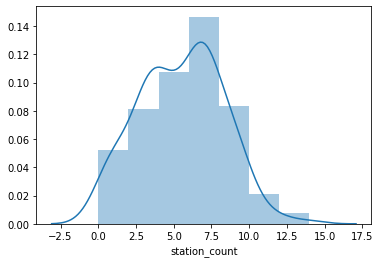

In [221]:
sns.distplot(station_data.station_count,bins=7)

#### The distribution has a non zero right skewed distribution characteristic of a poisson distribution. 

A QQ-plot is shown below to see if the data lines up to the expected quiantiles

((array([ 0.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
          2.,  2.,  2.,  2.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
          3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,  3.,
          4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
          4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
          4.,  4.,  4.,  4.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
          5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,
          5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  5.,  6.,  6.,
          6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
          6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,  6.,
          6.,  6.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,
          7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  8.,
          8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
          8.,  8.,  9.,  9.,  9.,  9.,

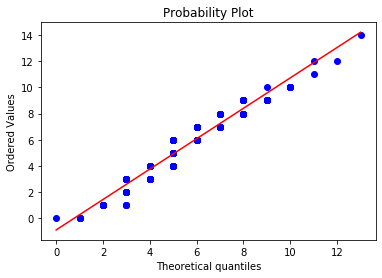

In [222]:
import scipy.stats as stats
stats.probplot(station_data.station_count,station_data.station_count.mean(),dist="poisson",plot=plt)

### The QQ-Plot is suggesting a poisson as well.
To check its statistical significance, I did a Kolmogorov-Smirnov test for goodness of fit

In [223]:
stats.kstest(station_data.station_count,"poisson",args=[station_data.station_count.mean()])

KstestResult(statistic=0.22663863523539407, pvalue=4.198366184302112e-09)

P Value is very significant. I am quite confident that this data follows a poisson distribution which is an expected but interesting discovery and could inform how we model this relationship in the future. 

## Exploratory Analysis Part 2: Feature Correlation Analysis

To assess how the features are related to eachother and the number of gas stations, a seaborn pairplot was done to assess the relationships.

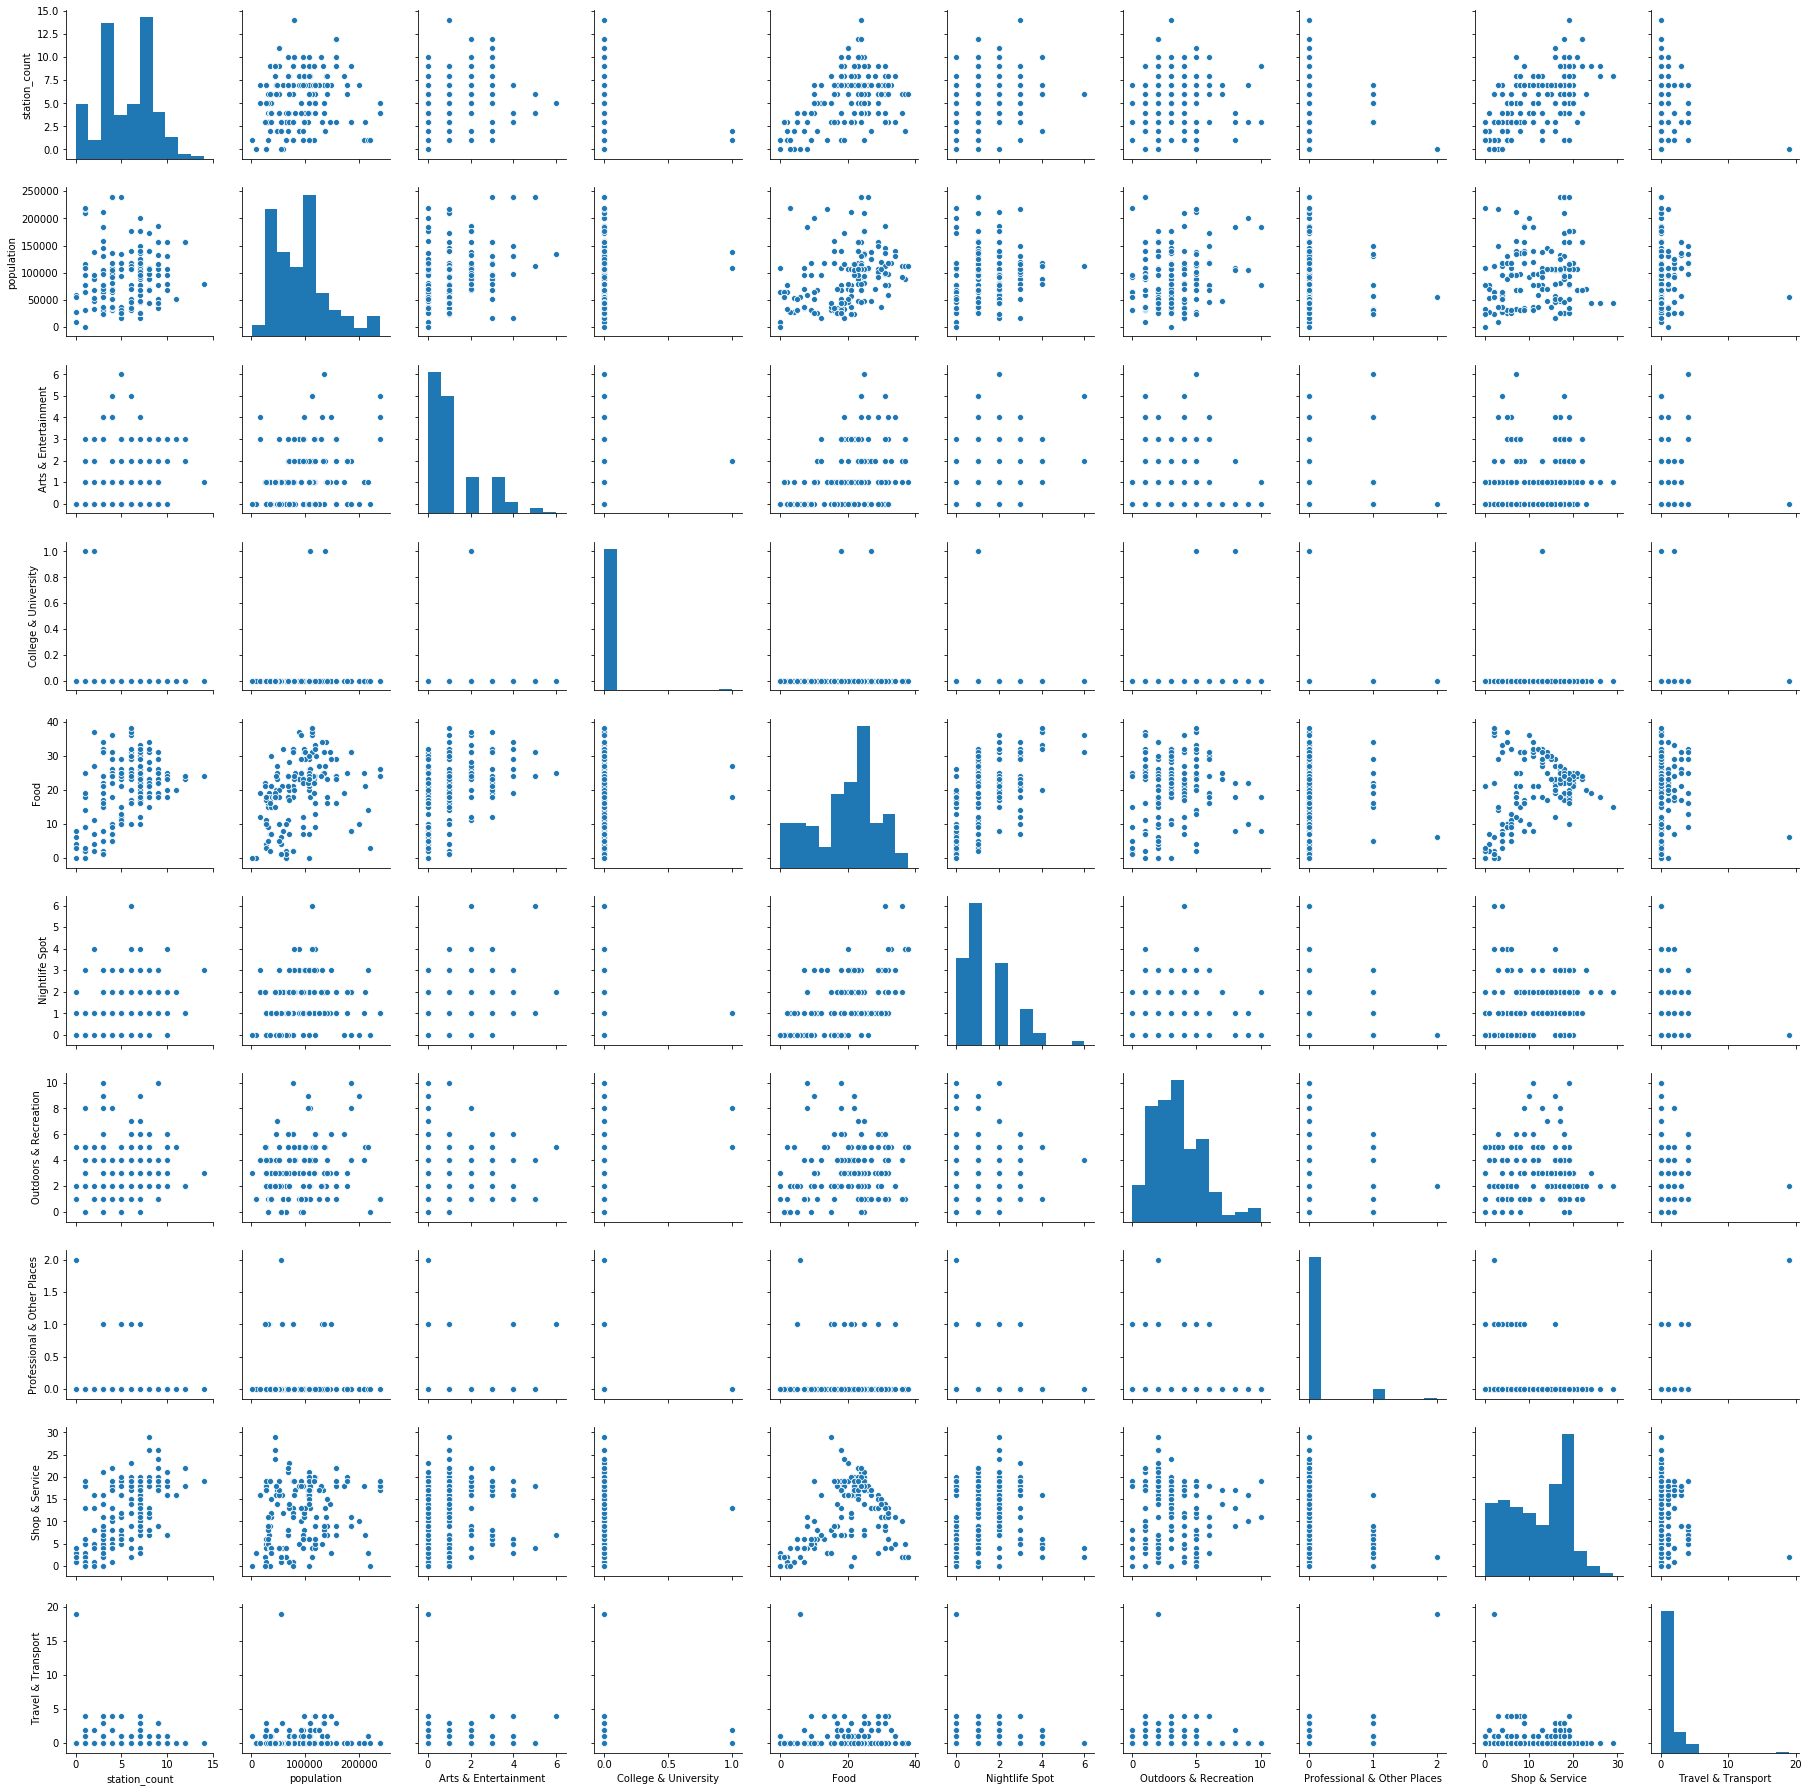

In [224]:
sns.pairplot(station_data)
plt.show()

#### Food and Shop & Service seem to have strong linear correlations. 
College and University, Travel and transport, Profession and other places and Arts and Entertainment have very week correlations so will be excluded from further analysis. 

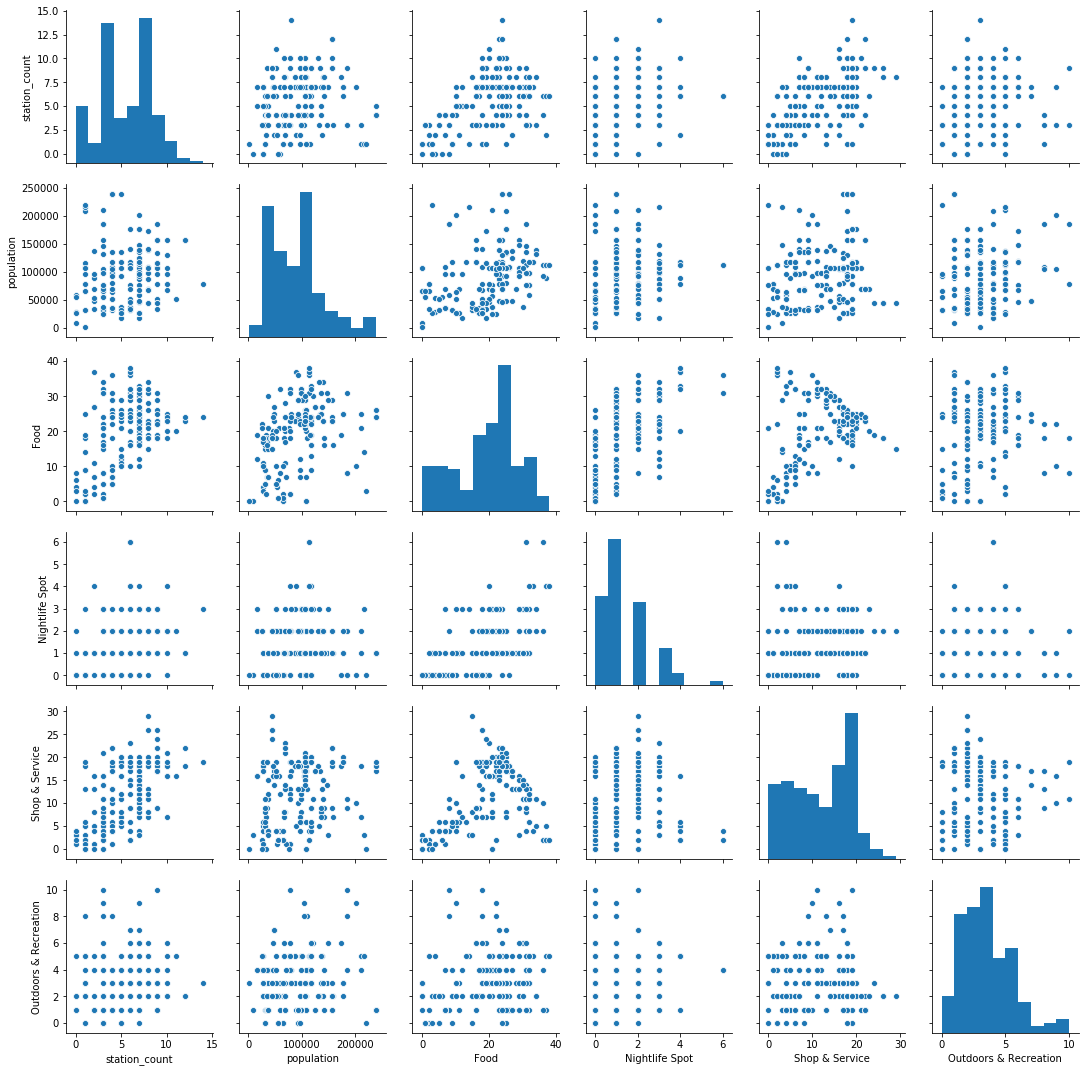

In [349]:
relavent_columns = ["station_count","population","Food","Nightlife Spot","Shop & Service","Outdoors & Recreation"]
station_data = station_data[relavent_columns]
sns.pairplot(station_data)

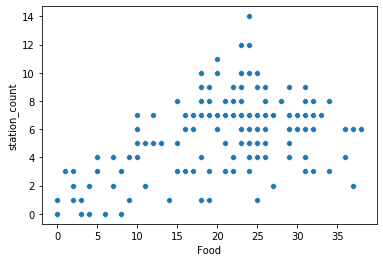

In [351]:
sns.scatterplot(x="Food",y="station_count",data=station_data)

## Building the predictive model

This is a regression problem. 4 different varaties of regression will be used and compared in the analysis. 
1. OLS Linear Regression
2. Ridge Regression
3. Random Forest Regression. 
4. Poisson Regression

First, a 20:80 train test split is constructed

In [323]:
from sklearn.model_selection import train_test_split
relavent_columns = ["station_count","population","Food","Nightlife Spot","Shop & Service","Outdoors & Recreation"]
X = station_data[relavent_columns[1:]]
y = station_data["station_count"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Standard Scalers are applied to scale the values properly. This is especially important for the population with has a larger scale than the other data.Both and OLS and ridge regression are done.

In [324]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
#('scale',MinMaxScaler()),
ols = Pipeline([('ols',LinearRegression())])
ridge = Pipeline([('ridge',RidgeCV())])


#### Model Comparison Strategy
To compare the different models, a cross validation strategy is used. The negative meansquared error is used but converted to the more interpretable root-mean squared error (RMSE) when comparing

In [325]:
from sklearn.model_selection import cross_validate

ols_train_results = cross_validate(ols,X=X_train,y=y_train,cv=5,scoring='neg_mean_squared_error')
ridge_train_results = cross_validate(ridge,X=X_train,y=y_train,cv=5,scoring='neg_mean_squared_error')

#### OLS RMSE

In [326]:
np.sqrt(ols_train_results["test_score"].mean()*-1)

2.1725326628089094

#### Ridge RMSE

In [327]:
np.sqrt(ridge_train_results["test_score"].mean()*-1)

2.172898933651395

Both OLS and Ridge regression have similar RMSE values. It doesnt appear that the Ridge regression had any affect on its predictive power. 

#### Random forest regressor. 

Tuning the max_depth hyper parameter is important for getting a good score. 

In [352]:
error = []
depths = range(2,10)
for i in depths:
    tree = Pipeline([('tree',RandomForestRegressor(max_depth=i))])
    result = np.sqrt(cross_validate(tree,X=X_train,y=y_train,cv=5,scoring='neg_mean_squared_error')["test_score"].mean()*-1)
    error.append(result)

tree_errors = pd.DataFrame({"depths":depths,"error":error})
tree_errors

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: F

,depths,error
0,2,2.212175
1,3,2.195473
2,4,2.144998
3,5,2.191526
4,6,2.302311
5,7,2.226428
6,8,2.152074
7,9,2.286091


In [353]:
tree = Pipeline([('tree',RandomForestRegressor(max_depth=4))])

Based on the different max depths tested, 4 seems to give the best score and does comparibly to the OLS and Ridge regression.

#### Poisson GLM Regression

Due to the proof of the Poisson distribution, a poisson regression model was also attempted. The version of scikit learn I am using does not have this built in so I constructed a wrapper around the statsmodels implementation. 

In [329]:
from statsmodels.discrete.discrete_model import Poisson
from sklearn.base import RegressorMixin

class poisson_regressor(RegressorMixin):
    def fit(self, X, y):
        X = sm.add_constant(X)
        self.model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
    def predict(self,X):
        if self.model is not None:
            X = sm.add_constant(X)
            return self.model.predict(X)

poisson = Pipeline([('poisson',poisson_regressor())])
poisson_results = cross_validate(poisson,X=poisson_X_train,y=y_train,cv=5,scoring='neg_mean_squared_error')
np.sqrt(poisson_results["test_score"]*-1).mean()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is dep

2.1744963178443486

The Poisson regression performs similarily to the OLS and Rdige regression models

## Final Train and Test

These models seem to preform similarly. Combinations of features and scaling choices were done without any change to the predictive power of the models. The final models shown above were trained using the full train set and 

In [358]:
from sklearn.metrics import mean_squared_error
models = ["ols","ridge","tree","poisson"]
results = []
final_ols = ols.fit(X_train,y_train)
final_ridge = ridge.fit(X_train,y_train)
final_tree = tree.fit(X_train,y_train)
final_poisson = poisson.fit(X_train,y_train)

results.append(np.sqrt(mean_squared_error(y_test,final_ols.predict(X_test))))
results.append(np.sqrt(mean_squared_error(y_test,final_ridge.predict(X_test))))
results.append(np.sqrt(mean_squared_error(y_test,final_tree.predict(X_test))))
results.append(np.sqrt(mean_squared_error(y_test,final_poisson.predict(X_test))))

model_performance = pd.DataFrame({"models":models,"rmse_results":results})

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [359]:
model_performance

,models,rmse_results
0,ols,2.083854
1,ridge,2.075226
2,tree,1.874256
3,poisson,2.154290


## Visualization of Model predictions

In [341]:
ols_y = final_ols.predict(X_test)
ridge_y = final_ridge.predict(X_test)
tree_y = final_tree.predict(X_test)
poisson_y = final_poisson.predict(X_test)

models = pd.DataFrame({'count':y_test,"X":X_test["Food"],"ols_y":ols_y,"ridge_y":ridge_y,"tree_y":tree_y,"poisson_y":poisson_y})

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


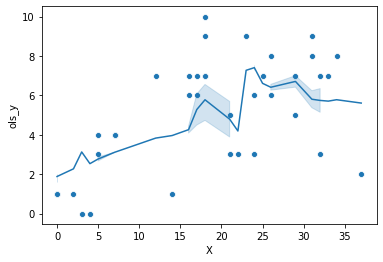

In [344]:
sns.scatterplot(x="X",y="count",data=models)
sns.lineplot(x="X",y="ols_y",data=models)

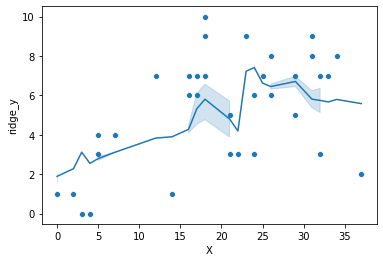

In [345]:
sns.scatterplot(x="X",y="count",data=models)
sns.lineplot(x="X",y="ridge_y",data=models)

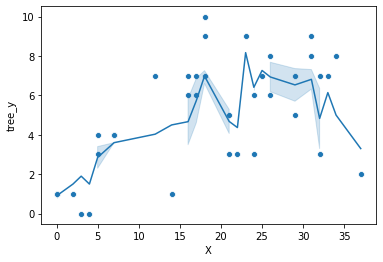

In [346]:
sns.scatterplot(x="X",y="count",data=models)
sns.lineplot(x="X",y="tree_y",data=models)

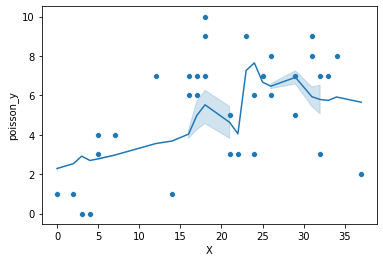

In [347]:
sns.scatterplot(x="X",y="count",data=models)
sns.lineplot(x="X",y="poisson_y",data=models)

# Discussion

Using the data collected on the number of venues and the population the model using the regression tree regression could predict the number of gas stations within a 2Km radius on average within approximately 2 gas stations. The analysis confirmed that the number of gas stations surrounding a gas station within 2Km follows a Poisson distribution. With this model city planning can be done to deny an additional gas station to be built where the model outputs a significantly lower number (< 2 already present) in the 2Km area. Therefore these areas can be used for other venues such as local businesses. It would also prevent that site from becoming unusable due to any leakages or accidents, further damaging the local environment and potential for business. 